In [1]:
# 필수 라이브러리 임포트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# 목표

보험료 인상에 영향을 미치는 속성들을 찾고 보험료 예측 모델 생성

### 컬럼

age: 개인의 나이 (연령)

gender: 개인의 성별 [male, female]

bmi: 체질량지수

children: 부양 가족 수 또는 자녀 수

smoker: 흡연 여부 [TRUE, FALSE]

region: 거주 지역 [northeast, southwest, northwest, southeast]

medical_history: 개인의 주요 의료 이력 [None, Heart disease, High blood pressure, Diabetes]

family_medical_history: 가족의 주요 의료 이력 [None, Heart disease, High blood pressure, Diabetes]

exercise_frequency: 개인의 운동 빈도 [Rarely, Occasionally, Frequently, Never]

occupation: 직업 유형 [Unemployed, Student, Blue collar, White collar]

coverage_level: 보험 보장 수준 [Basic, Standard, Premium]

charges: 보험 청구 금액

In [2]:
# 데이터 불러오기
raw_data = pd.read_csv("C:/Users/Owner/Desktop/insurance_dataset.csv")
raw_data.head()

,age,gender,bmi,children,smoker,region,medical_history,family_medical_history,exercise_frequency,occupation,coverage_level,charges
0,46,male,21.45,5,yes,southeast,Diabetes,NaN,Never,Blue collar,Premium,20460.307669
1,25,female,25.38,2,yes,northwest,Diabetes,High blood pressure,Occasionally,White collar,Premium,20390.899218
2,38,male,44.88,2,yes,southwest,NaN,High blood pressure,Occasionally,Blue collar,Premium,20204.476302
3,25,male,19.89,0,no,northwest,NaN,Diabetes,Rarely,White collar,Standard,11789.029843
4,49,male,38.21,3,yes,northwest,Diabetes,High blood pressure,Rarely,White collar,Standard,19268.309838


In [3]:
# DataFrame 생성
data = pd.DataFrame(raw_data)
data_copy = data.copy()

In [4]:
# 데이터 이해 코드
print(data_copy.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 12 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   age                     1000000 non-null  int64  
 1   gender                  1000000 non-null  object 
 2   bmi                     1000000 non-null  float64
 3   children                1000000 non-null  int64  
 4   smoker                  1000000 non-null  object 
 5   region                  1000000 non-null  object 
 6   medical_history         749238 non-null   object 
 7   family_medical_history  749596 non-null   object 
 8   exercise_frequency      1000000 non-null  object 
 9   occupation              1000000 non-null  object 
 10  coverage_level          1000000 non-null  object 
 11  charges                 1000000 non-null  float64
dtypes: float64(2), int64(2), object(8)
memory usage: 91.6+ MB
None


In [5]:

print(data_copy.describe())


                  age             bmi        children         charges
count  1000000.000000  1000000.000000  1000000.000000  1000000.000000
mean        41.495282       34.001839        2.499886    16735.117481
std         13.855189        9.231680        1.707679     4415.808211
min         18.000000       18.000000        0.000000     3445.011643
25%         29.000000       26.020000        1.000000    13600.372379
50%         41.000000       34.000000        2.000000    16622.127973
75%         53.000000       41.990000        4.000000    19781.465410
max         65.000000       50.000000        5.000000    32561.560374


In [6]:

print(data_copy.isnull().sum())

age                            0
gender                         0
bmi                            0
children                       0
smoker                         0
region                         0
medical_history           250762
family_medical_history    250404
exercise_frequency             0
occupation                     0
coverage_level                 0
charges                        0
dtype: int64



--- 상관 계수 ---
               age       bmi  children   charges
age       1.000000  0.001428 -0.001317  0.063390
bmi       0.001428  1.000000 -0.001635  0.104429
children -0.001317 -0.001635  1.000000  0.076801
charges   0.063390  0.104429  0.076801  1.000000


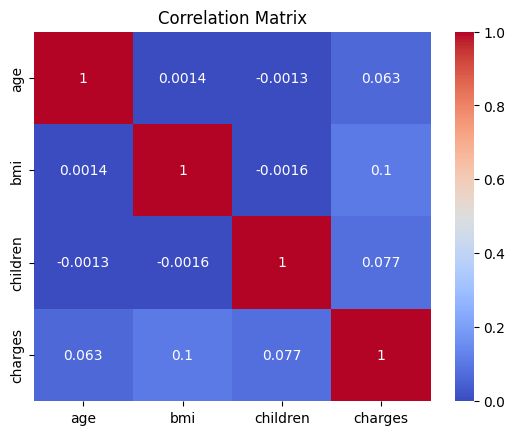

In [7]:
# 상관 분석 코드
numerical_cols = ["age", "bmi", "children", "charges"]
correlation_matrix = data_copy[numerical_cols].corr()
print("\n--- 상관 계수 ---")
print(correlation_matrix)

sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

In [8]:
# 결측값 처리 코드
data_copy["medical_history"].fillna("None", inplace=True)
data_copy["family_medical_history"].fillna("None", inplace=True)

C:\Users\Owner\AppData\Local\Temp\ipykernel_21488\1831194392.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_copy["medical_history"].fillna("None", inplace=True)
C:\Users\Owner\AppData\Local\Temp\ipykernel_21488\1831194392.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

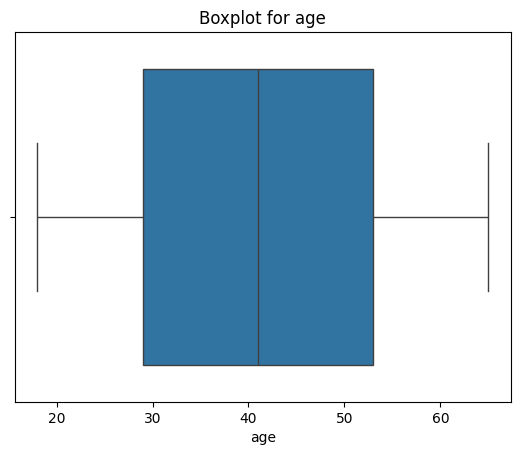

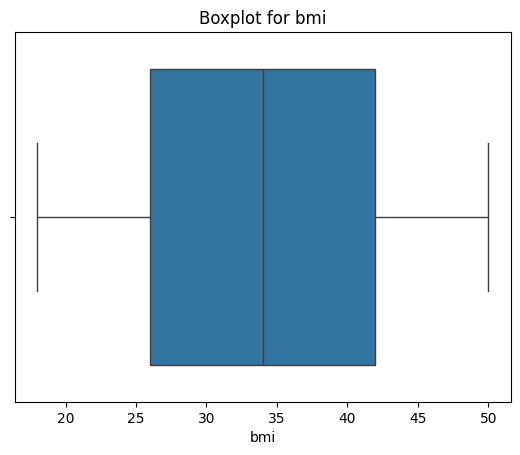

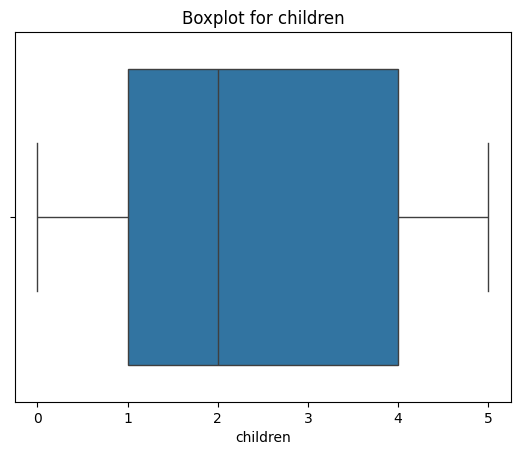

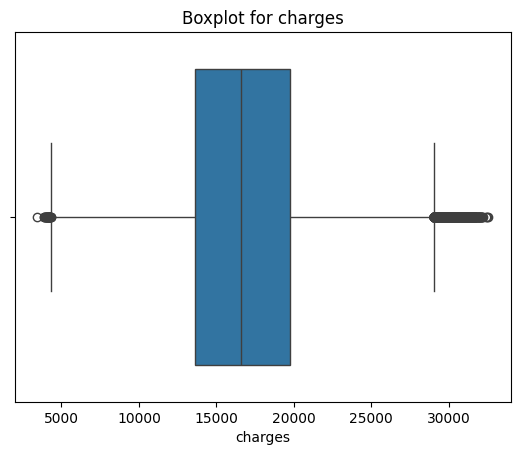

In [9]:
# 이상치 확인 및 제거 코드
for col in numerical_cols:
    sns.boxplot(x=data_copy[col])
    plt.title(f"Boxplot for {col}")
    plt.show()

In [10]:
# IQR로 이상치 제거 함수 정의
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

In [11]:
# 이상치 제거 적용
for col in numerical_cols:
    data_copy = remove_outliers(data_copy, col)

In [12]:
# 원-핫 인코딩 코드
categorical_cols = ["gender", "smoker", "region", "medical_history", "family_medical_history", "exercise_frequency", "occupation", "coverage_level"]

# 원-핫 인코딩 적용
data_copy = pd.get_dummies(data_copy, columns=categorical_cols, drop_first=True)

In [13]:
# 스케일링 코드
scaler = StandardScaler()
data_copy[numerical_cols] = scaler.fit_transform(data_copy[numerical_cols])


In [14]:
# 상관 계수 결과 확인
print(data_copy.corr())

                                                 age       bmi  children  \
age                                         1.000000  0.001228 -0.001414   
bmi                                         0.001228  1.000000 -0.001883   
children                                   -0.001414 -0.001883  1.000000   
charges                                     0.062224  0.102616  0.075477   
gender_male                                -0.001390 -0.001386  0.000433   
smoker_yes                                  0.000214 -0.001204 -0.000597   
region_northwest                           -0.000927 -0.001735 -0.000224   
region_southeast                            0.000842  0.000962  0.000756   
region_southwest                            0.000865  0.001087  0.000065   
medical_history_Heart disease               0.000260 -0.001106 -0.001878   
medical_history_High blood pressure         0.000202  0.000544  0.000335   
medical_history_None                       -0.000015  0.001650  0.001204   
family_medic

## 모델링

In [15]:
# 보험료 예측 모델 코드
X = data_copy.drop("charges", axis=1)
y = data_copy["charges"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [16]:
# 모델 1: 선형 회귀 (Linear Regression)
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# 예측 및 평가
y_pred_lr = linear_model.predict(X_test)
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print("\n--- Linear Regression Results ---")
print(f"Mean Squared Error (MSE): {mse_lr:.4f}")
print(f"R^2 Score: {r2_lr:.4f}")


--- Linear Regression Results ---
Mean Squared Error (MSE): 0.0044
R^2 Score: 0.9956


In [17]:
# 모델 2: 랜덤 포레스트 하이퍼파라미터 튜닝
rf_param_grid = {
    "n_estimators": [50, 100],  
    "max_depth": [5, 10],      
    "min_samples_split": [2, 5], 
    "min_samples_leaf": [1, 2]    
}
rf_model = RandomForestRegressor(random_state=42)
rf_grid = GridSearchCV(
    estimator=rf_model, 
    param_grid=rf_param_grid, 
    scoring="r2", 
    cv=2,  # 교차 검증 폴드 수를 2로 줄임 (기본값은 5)
    n_jobs=-1
)
rf_grid.fit(X_train, y_train)
best_rf_model = rf_grid.best_estimator_

# 최적의 하이퍼파라미터 출력
print("\n--- Best Hyperparameters for Random Forest ---")
print(rf_grid.best_params_)


--- Best Hyperparameters for Random Forest ---
{'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}


In [18]:
# 모델 3: 그래디언트 부스팅 하이퍼파라미터 튜닝 
gb_param_grid = {
    "n_estimators": [50, 100],  
    "learning_rate": [0.05, 0.1],  
    "max_depth": [3, 5],          
    "min_samples_split": [2, 5],  
    "min_samples_leaf": [1, 2]    
}
gb_model = GradientBoostingRegressor(random_state=42)
gb_grid = GridSearchCV(
    estimator=gb_model, 
    param_grid=gb_param_grid, 
    scoring="r2", 
    cv=2,  # 교차 검증 폴드 수를 2로 줄임
    n_jobs=-1
)
gb_grid.fit(X_train, y_train)
best_gb_model = gb_grid.best_estimator_

# 최적의 하이퍼파라미터 출력
print("\n--- Best Hyperparameters for Gradient Boosting ---")
print(gb_grid.best_params_)



--- Best Hyperparameters for Gradient Boosting ---
{'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [19]:
# 결과 출력
models = ["Linear Regression", "Random Forest", "Gradient Boosting"]
results = {}

In [20]:
# 선형 회귀
y_pred_lr = linear_model.predict(X_test)
results["Linear Regression"] = {
    "MSE": mean_squared_error(y_test, y_pred_lr),
    "R^2": r2_score(y_test, y_pred_lr)
}

In [21]:
# 랜덤 포레스트
y_pred_rf = best_rf_model.predict(X_test)
results["Random Forest"] = {
    "MSE": mean_squared_error(y_test, y_pred_rf),
    "R^2": r2_score(y_test, y_pred_rf)
}


In [22]:
# 그래디언트 부스팅
y_pred_gb = best_gb_model.predict(X_test)
results["Gradient Boosting"] = {
    "MSE": mean_squared_error(y_test, y_pred_gb),
    "R^2": r2_score(y_test, y_pred_gb)
}

In [23]:
# 결과 출력
for model, metrics in results.items():
    print(f"\n--- {model} Results ---")
    print(f"Mean Squared Error (MSE): {metrics['MSE']:.4f}")
    print(f"R^2 Score: {metrics['R^2']:.4f}")


--- Linear Regression Results ---
Mean Squared Error (MSE): 0.0044
R^2 Score: 0.9956

--- Random Forest Results ---
Mean Squared Error (MSE): 0.0518
R^2 Score: 0.9481

--- Gradient Boosting Results ---
Mean Squared Error (MSE): 0.0065
R^2 Score: 0.9935


In [24]:
# 시각화
mse_scores = [metrics["MSE"] for metrics in results.values()]
r2_scores = [metrics["R^2"] for metrics in results.values()]

plt.figure(figsize=(10, 5))

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

Text(0, 0.5, 'MSE')

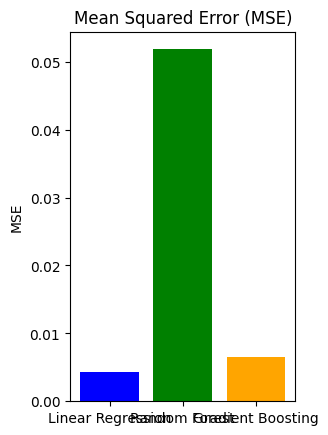

In [25]:
# MSE 비교
plt.subplot(1, 2, 1)
plt.bar(models, mse_scores, color=["blue", "green", "orange"])
plt.title("Mean Squared Error (MSE)")
plt.ylabel("MSE")

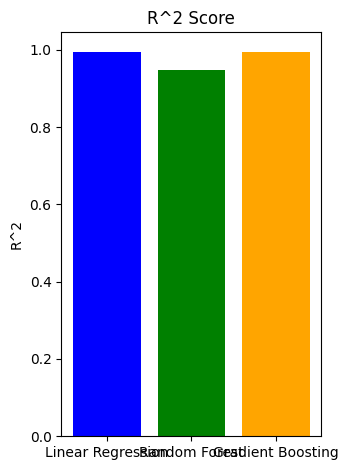

In [26]:
# R^2 비교
plt.subplot(1, 2, 2)
plt.bar(models, r2_scores, color=["blue", "green", "orange"])
plt.title("R^2 Score")
plt.ylabel("R^2")
plt.tight_layout()
plt.show()


--- Feature Importance (Linear Regression) ---
                                       Feature  Importance
20                      coverage_level_Premium    1.142113
4                                   smoker_yes    1.141983
11        family_medical_history_Heart disease    0.685376
8                medical_history_Heart disease    0.685280
10                        medical_history_None   -0.456873
13                 family_medical_history_None   -0.456870
21                     coverage_level_Standard    0.456770
14                    exercise_frequency_Never   -0.456729
16                   exercise_frequency_Rarely   -0.342415
18                       occupation_Unemployed   -0.342277
9          medical_history_High blood pressure   -0.228674
3                                  gender_male    0.228397
12  family_medical_history_High blood pressure   -0.228293
17                          occupation_Student   -0.228087
15             exercise_frequency_Occasionally   -0.227962
7       

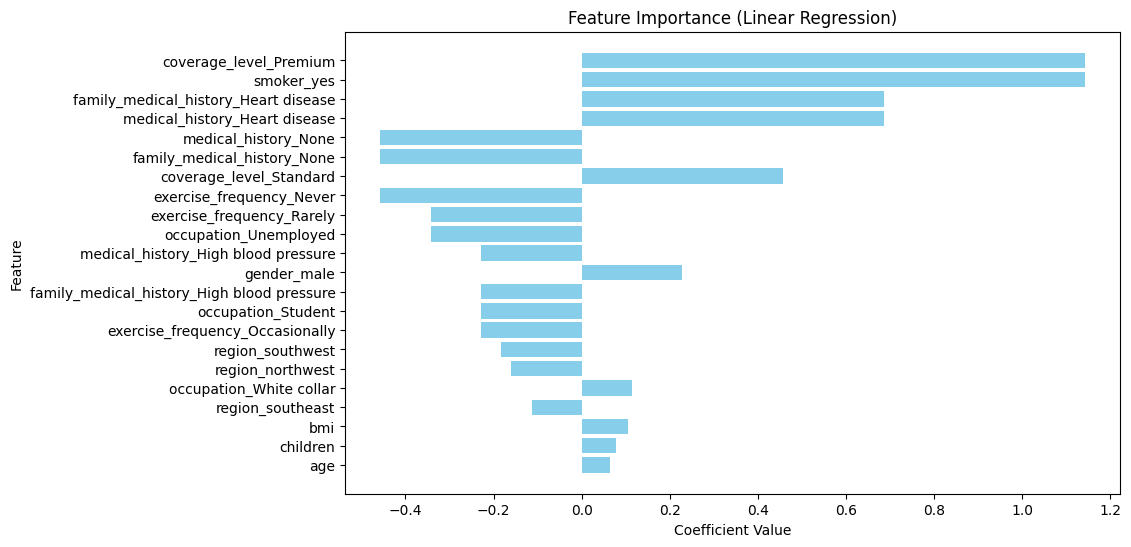

In [27]:
# 피처 중요도 계산 (선형회귀)
coefficients = linear_model.coef_  # 회귀 계수 추출
feature_names = X_train.columns  # 피처 이름 추출

# 데이터프레임으로 정리
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": coefficients
}).sort_values(by="Importance", key=abs, ascending=False)  # 절대값 기준 정렬

# 피처 중요도 출력
print("\n--- Feature Importance (Linear Regression) ---")
print(importance_df)

# 시각화
plt.figure(figsize=(10, 6))
plt.barh(importance_df["Feature"], importance_df["Importance"], color="skyblue")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.title("Feature Importance (Linear Regression)")
plt.gca().invert_yaxis()  # 상위 중요도가 위로 오도록 정렬
plt.show()

### 주요 인사이트

#### 의료비(charges)의 주요 영향

1. 보험 보장 수준 (coverage_level_Premium): 가장 큰 양의 영향
2. 흡연 여부 (smoker_yes): 의료비를 크게 증가시키는 요인
3. 심장 질환 병력 (medical_history_Heart disease, family_medical_history_Heart disease): 병력과 가족력이 모두 중요한 영향을 미침
4. 운동 빈도와 의료 기록: 운동을 하지 않거나 의료 기록이 없는 경우 의료비 감소

#### 의미 있는 결과 활용
1. 보험사 관점: 흡연, 가족력, 병력 정보가 보험료 산정 및 정책 수립에 중요한 요소로 활용 가능
2. 개인 건강 관점: 심장 질환 예방 및 금연이 의료비를 줄이는 데 기여 가능